In [10]:
# Importing
%load_ext autoreload
%autoreload 2
import os
import sys
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import src.helpers.model_helpers as mh

# Finding the root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import src.utils.file_utils as fu
import src.helpers.feature_engineering_helper as feh

cfg_schema = fu.load_config("schema")
cfg_feature_engineering = fu.load_config("feature_engineering")["feature_engineering"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Reading the Processed data set
X_train, y_train, X_test, y_test = mh.load_model_dataset()

Loading dataset from /Users/c1burns/Documents/UTD/BUAN 6341/project_repo/data/processed/hmda_2024_model.parquet


In [12]:
# Log transform skewed continuous features prior to scaling
X_train = feh.log_transform_skewed_features(X_train)

In [13]:
# Loading the scaler and scaling the numerical values
numeric_cols = ['loan_amount', 'income', 'combined_loan_to_value_ratio', 'loan_term', 'intro_rate_period', 'prepayment_penalty_term',
                'property_value', 'loan_to_income_ratio', 'debt_to_income_ratio_60100_x_loan_to_income_ratio', 'debt_to_income_ratio_5060_x_loan_to_income_ratio', 'debt_to_income_ratio_4850_x_loan_to_income_ratio', 'debt_to_income_ratio_4547_x_loan_to_income_ratio']

scaler = joblib.load(os.path.join(project_root, 'models', 'scaler.pkl'))
df_scaled = scaler.transform(X_train[numeric_cols])
numeric_df = pd.DataFrame(df_scaled, columns=numeric_cols)

In [14]:
# Loading the categorical variables
cat_cols = [c for c in X_train.columns if c not in numeric_cols]
X_train_cat = X_train[cat_cols]

In [22]:
# Fit SVD
n_components = 20
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_cat_svd = svd.fit_transform(X_train_cat)

print(f"SVD explained variance (sum): {svd.explained_variance_ratio_.sum()}")

SVD explained variance (sum): 0.8031993651508061


In [16]:
# Saving the SVD object
svd_path = os.path.join(project_root, 'models','svd.pkl')
os.makedirs(os.path.dirname(svd_path), exist_ok=True)
joblib.dump(svd, svd_path)

['/Users/c1burns/Documents/UTD/BUAN 6341/project_repo/models/svd.pkl']

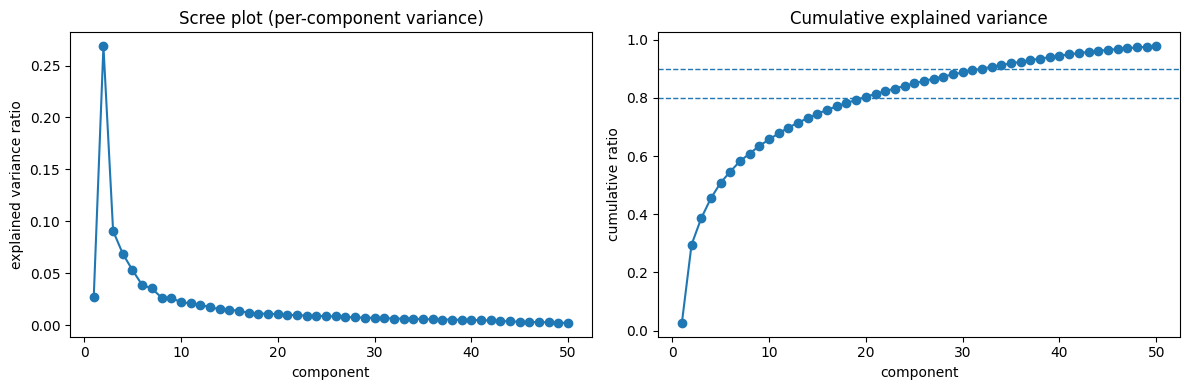

In [17]:
# Scree plot / Cumulative explained variance
svd_diag = TruncatedSVD(n_components=50, random_state=42).fit(X_train_cat)
evr = svd_diag.explained_variance_ratio_
cum = np.cumsum(evr)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(range(1, len(evr)+1), evr, marker='o')
ax[0].set_title("Scree plot (per-component variance)")
ax[0].set_xlabel("component")
ax[0].set_ylabel("explained variance ratio")

ax[1].plot(range(1, len(cum)+1), cum, marker='o')
ax[1].axhline(0.8, ls="--", lw=1)
ax[1].axhline(0.9, ls="--", lw=1)
ax[1].set_title("Cumulative explained variance")
ax[1].set_xlabel("component")
ax[1].set_ylabel("cumulative ratio")
plt.tight_layout()
plt.show()

In [18]:
# Which components contribute most?
def top_loadings(svd, feature_names, k=10):
    # components_: shape (n_components, n_features)
    comps = svd.components_
    out = {}
    for i, vec in enumerate(comps, start=1):
        idx = np.argsort(np.abs(vec))[::-1][:k]
        out[f"comp_{i}"] = [(feature_names[j], float(vec[j])) for j in idx]
    return out

top10 = top_loadings(svd, list(X_train_cat.columns), k=10)
for comp, pairs in top10.items():
    print(f"\n{comp} top features:")
    for name, weight in pairs:
        print(f"  {name:60s} {weight:+.4f}")


comp_1 top features:
  negative_amortization_False                                  +0.2042
  other_non_amortizing_features_False                          +0.2040
  reverse_mortgage_False                                       +0.2038
  preapproval_False                                            +0.1987
  manufactured_home_secured_property_type_not_applicable       +0.1973
  construction_method_site                                     +0.1970
  initially_payable_to_institution_True                        +0.1947
  applicant_race_observed_not_collected                        +0.1946
  applicant_ethnicity_observed_not_collected                   +0.1946
  applicant_sex_observed_not_collected                         +0.1945

comp_2 top features:
  co_applicant_race_observed_not_collected                     +0.2645
  co_applicant_ethnicity_observed_not_collected                +0.2644
  co_applicant_sex_observed_not_collected                      +0.2643
  co_applicant_sex_observed_no_co